1. Data loading and cleaning
2. Object Detection
    1. Two stage detector: RNN
    2. Single stage detector: YOLO
3. Segmentation
    1. YOLO

In [21]:
# Download the dataset from Kaggle
import kaggle
kaggle.api.authenticate()

kaggle.api.dataset_download_files('mbkinaci/fruit-images-for-object-detection', path='.', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection


In [30]:
# Only when loading and preparing the dataset for the first time !!!

import xml.etree.ElementTree as ET
import PIL.Image

def convert_annotation(label_file):

    new_label_file = label_file.split('.')[0] + '.txt' # Create a new label .txt label files

    tree = ET.parse(label_file) # Parse the xml file
    root = tree.getroot() # Get the root of the xml file

    image_w = int(root.find("size/width").text) # Get the width of the image, used to normalize the bounding box
    image_h = int(root.find("size/height").text) # Get the height of the image, used to normalize the bounding box

    if image_w == 0 or image_h == 0: # This coudl happen if the image does not have any background
        image = PIL.Image.open(label_file.replace('xml', 'jpg'))
        image_w, image_h = image.size

    if image_w == 0 or image_h == 0: # If sthill the image size is 0, return True
        print(f'Error with image size: {label_file}')
        return True
    
    yolo_annotations = [] # List to store the annotations in YOLO format

    map_class = {'apple': 0, 'banana': 1, 'orange': 2} # Dictionary to map the class name to a class index

    for obj in root.iter("object"):
        class_name = obj.find("name").text # Get the class name (Orange, Apple, Banana)

        obj_id = map_class[class_name]

        bbox_w = (int(obj.find("bndbox/xmax").text) - int(obj.find("bndbox/xmin").text)) / image_w # Calculate the width of the bounding box and normalize it
        bbox_h = (int(obj.find("bndbox/ymax").text) - int(obj.find("bndbox/ymin").text)) / image_h # Calculate the height of the bounding box and normalize it

        bbox_c_x = (int(obj.find("bndbox/xmin").text) / image_w + (bbox_w / 2)) # Calculate the center x of the bounding box and normalize it
        bbox_c_y = (int(obj.find("bndbox/ymin").text) / image_h + (bbox_h / 2)) # Calculate the center y of the bounding box and normalize it

        yolo_annotations.append(f"{obj_id} {bbox_c_x} {bbox_c_y} {bbox_w} {bbox_h}")# Append the annotation in YOLO format


    with open(new_label_file, "w") as f:
        f.write("\n".join(yolo_annotations))

    return False # No errors

In [23]:
# Only when loading and preparing the dataset for the first time !!!

# Prepare the dataset in YOLO format
import os
from sklearn.model_selection import train_test_split
import shutil

# Get the list of images
file_list = [os.path.join('fruit_detection', image_folder, image_name)
             for image_folder in os.listdir('fruit_detection')
             for image_name in os.listdir(os.path.join('fruit_detection', image_folder))
             if image_name.endswith('.jpg')]


print(f'Overall {len(file_list)} images found')

# Create the directory structure
os.makedirs(os.path.join(os.getcwd(), 'fruit_detection', 'images'),  exist_ok=True) # Create the directory to store the images
# Create train-test-validation directories
os.makedirs(os.path.join(os.getcwd(), 'fruit_detection', 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(os.getcwd(), 'fruit_detection', 'images', 'test'), exist_ok=True)
os.makedirs(os.path.join(os.getcwd(), 'fruit_detection', 'images', 'valid'), exist_ok=True)

os.makedirs(os.path.join(os.getcwd(), 'fruit_detection', 'labels' ),  exist_ok=True) # Create the directory to store the labels
# Create train-test-validation directories
os.makedirs(os.path.join(os.getcwd(), 'fruit_detection', 'labels', 'train'), exist_ok=True)
os.makedirs(os.path.join(os.getcwd(), 'fruit_detection', 'labels', 'test'), exist_ok=True)
os.makedirs(os.path.join(os.getcwd(), 'fruit_detection', 'labels', 'valid'), exist_ok=True)

os.makedirs(os.path.join(os.getcwd(), 'fruit_detection', 'xml_labels'), exist_ok=True) # Create the directory to store the weights

# Train, Test, Validation split
train_files, temp_file = train_test_split(file_list, test_size=0.2)
test_files, valid_files = train_test_split(temp_file, test_size=0.5)

print(f'Train: {len(train_files)} images')
print(f'Test: {len(test_files)} images')
print(f'Validation: {len(valid_files)} images')

def moove_files(files, directory):
    for file in files:
        file_name = file.split('/')[-1]
        
        error = convert_annotation(file.replace('.jpg', '.xml')) # Convert the annotation to YOLO format
        
        if not error: # If there is an error, skip the image
            shutil.move(file, os.path.join(os.getcwd(), 'fruit_detection', 'images', directory, file_name)) # Move the image to the defined directory directory
            shutil.move(file.replace(".jpg", ".txt"), os.path.join(os.getcwd(), 'fruit_detection', 'labels', directory, file_name.replace(".jpg", ".txt")))
            shutil.move(file.replace(".jpg", ".xml"), os.path.join(os.getcwd(), 'fruit_detection', 'xml_labels', file_name.replace(".jpg", ".xml")))

moove_files(train_files, 'train')
moove_files(test_files, 'test')
moove_files(valid_files, 'valid')



Overall 300 images found
Train: 240 images
Test: 30 images
Validation: 30 images


In [24]:
# Only when loading and preparing the dataset for the first time !!!

for folder in os.listdir('fruit_detection'):
    if folder != 'images' and folder != 'labels' and folder != 'xml_labels':
        shutil.rmtree(os.path.join('fruit_detection', folder)) # Remove the folders that are not needed

In [1]:
def read_label(label_file):
    with open(label_file, 'r') as f:
        return f.read().split('\n')

In [3]:
# Plot a set of examples

import matplotlib.pyplot as plt
from PIL import Image


def plot_samples(file_list, labels):
    class_names = ['Apple', 'Banana', 'Orange']

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    for i, file in enumerate(file_list):
        img = Image.open(file).convert('RGB')
        axs[i // 3, i % 3].imshow(img)
        axs[i // 3, i % 3].axis('off')
        axs[i // 3, i % 3].set_title(file.split('/')[-1])

        if type(labels[i]) == str:
            lab_list = read_label(labels[i])
                    
        else:
            lab_list = labels[i]

        for line in lab_list:
            if line:
                if type(line) == str:
                    obj_id, bbox_c_x, bbox_c_y, bbox_w, bbox_h = map(float, line.split()) # Get the bounding box coordinates

                    # Normalize the bounding box coordinates
                    
                    x = (bbox_c_x - (bbox_w / 2)) * img.size[0] # Calculate the minimum x of the bounding box
                    y = (bbox_c_y - (bbox_h / 2)) * img.size[1] # Calculate the minimum y of the bounding box
                
                    w = bbox_w * img.size[0]
                    h = bbox_h * img.size[1]

                else: # This is for the prediction of the model
                    obj_id, bbox_x_min, bbox_y_min, bbox_x_max, bbox_y_max = line

                    # Real shape cooridinates

                    x = bbox_x_min
                    y = bbox_y_min

                    w = bbox_x_max - bbox_x_min
                    h = bbox_y_max - bbox_y_min

                    obj_id = int(obj_id)-1

                rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
                axs[i // 3, i % 3].add_patch(rect)

                label = class_names[int(obj_id)]  # Convert class ID to label name
                axs[i// 3, i % 3].text(
                    x + w, y, label, color='red', fontsize=10,
                    bbox=dict(facecolor='white', edgecolor='red', alpha=0.7))
    return fig


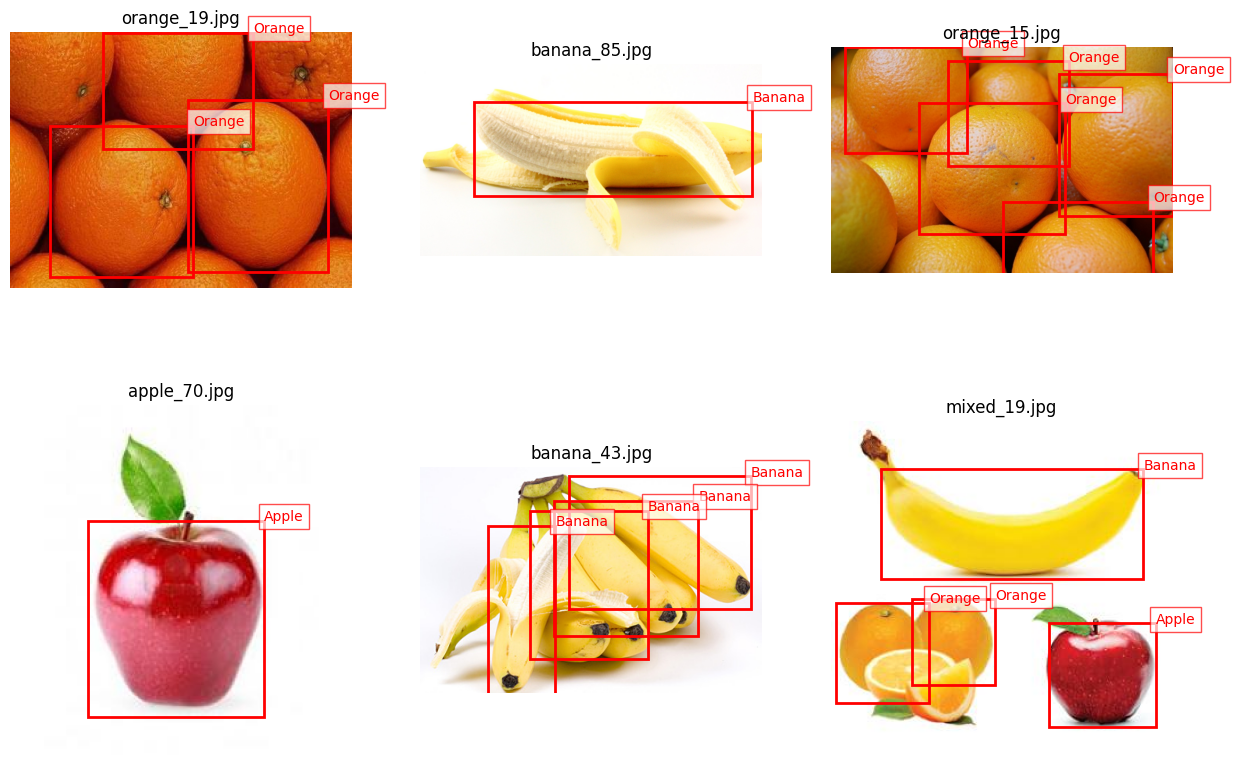

In [4]:
# Display a sample of 6 random image

import matplotlib.pyplot as plt
import numpy as np
import os

# Get the list of images

file_list = np.random.choice(os.listdir(os.path.join(os.getcwd(), 'fruit_detection', 'images', 'train')), 6)
file_list = [os.path.join(os.getcwd(), 'fruit_detection', 'images', 'train', file.split('/')[-1]) for file in file_list]
labels = [file.replace('.jpg', '.txt').replace('images', 'labels') for file in file_list]

fig = plot_samples(file_list, labels)
plt.show()
    

In [4]:
# List all the occurences of the classes in the dataset


def list_occurences(data_split, data_dict):

    paths = [os.path.join('fruit_detection', 'labels', data_split, file) for file in os.listdir(os.path.join('fruit_detection', 'labels', data_split))]

    for path in paths:
        with open(path, 'r') as f:
            for line in f:
                obj_id = int(line.split()[0])
                if obj_id == 0:
                    data_dict['apple'] += 1
                elif obj_id == 1:
                    data_dict['banana'] += 1
                elif obj_id == 2:
                    data_dict['orange'] += 1
   
train = {'apple': 0, 'banana': 0, 'orange': 0}
test = {'apple': 0, 'banana': 0, 'orange': 0}
valid = {'apple': 0, 'banana': 0, 'orange': 0}

list_occurences('train', train)
list_occurences('test', test)
list_occurences('valid', valid)

print(f'Train: {train}')
print(f'Test: {test}')
print(f'Validation: {valid}')


Train: {'apple': 166, 'banana': 169, 'orange': 142}
Test: {'apple': 11, 'banana': 26, 'orange': 22}
Validation: {'apple': 14, 'banana': 14, 'orange': 18}


### Fast R-CNN

In [1]:
def read_label(label_file):
    with open(label_file, 'r') as f:
        return f.read().split('\n')

In [6]:
import torch
from torchvision import datasets, transforms
import os
from PIL import Image

# Create the dataset class

class FruitDetectionDataset(datasets.ImageFolder):
    
    def __init__(self, image_path, transform=None):
        self.transform = transform        
        self.image_path = image_path

        self.image_list = [os.path.join(self.image_path, file) for file in os.listdir(self.image_path)]

    def __getitem__(self, index):
        
        image_path = self.image_list[index]
        image = Image.open(image_path).convert('RGB')

        image_w, image_h = image.size[0], image.size[1]

        label_file = image_path.replace('.jpg', '.txt').replace('images', 'labels')

        if self.transform:
            image = self.transform(image)
            image_w, image_h = image.shape[2], image.shape[1]

        bboxes = []
        items = []

        for line in read_label(label_file):
            if line:
                obj_id, bbox_c_x, bbox_c_y, bbox_w, bbox_h = map(float, line.split())
                
                x_min = (bbox_c_x - (bbox_w / 2)) * image_w  # Calculate the minimum x of the bounding box
                y_min = (bbox_c_y - (bbox_h / 2)) * image_h # Calculate the minimum y of the bounding box

                x_max =  (bbox_c_x + (bbox_w / 2)) * image_w # Calculate the maximum x of the bounding box
                y_max = (bbox_c_y + (bbox_h / 2)) * image_h # Calculate the maximum y of the bounding box

                bboxes.append([x_min, y_min, x_max, y_max]) # Append the bounding box
                
                items.append(obj_id+1)                     # Append the class ID (0==Apple, 1==Banana, 2==Orange)

        target = {}
        target['boxes'] = torch.tensor(bboxes, dtype=torch.float32)
        target['labels'] = torch.tensor(items, dtype=torch.int64)

        
        return image, target
        
    def __len__(self):
        return len(self.image_list)


In [7]:
# Get the list of images for train, test and validation
from torchvision import datasets, transforms
import os

train_data = os.listdir(os.path.join('fruit_detection', 'images', 'train'))
test_data = os.listdir(os.path.join('fruit_detection', 'images', 'test'))
valid_data = os.listdir(os.path.join('fruit_detection', 'images', 'valid'))


transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.0],[1.0])        # Normalize the images between 0 and 1 as the rcnn model expects
])

# Create the dataset

train_dataset = FruitDetectionDataset(os.path.join('fruit_detection', 'images', 'train'), transform=transform)
test_dataset = FruitDetectionDataset(os.path.join('fruit_detection', 'images', 'test'), transform=transform)
valid_dataset = FruitDetectionDataset(os.path.join('fruit_detection', 'images', 'valid'), transform=transform)



In [8]:
# Print the first element of the train dataset

image, label = train_dataset[0]

print(f'Image shape: {image.shape}')

print(f'Label: \n {label}')

Image shape: torch.Size([3, 224, 224])
Label: 
 {'boxes': tensor([[ 20.2222,   8.4000, 215.6000,  89.6000],
        [ 37.3333,  49.4667, 219.9556, 194.1333],
        [ 86.8000,   6.5333, 224.0000, 143.7333]]), 'labels': tensor([2, 2, 2])}


In [9]:
# Create the FastRCNN architecture
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.nn as nn


class FruitDET(nn.Module):

  def __init__(self):
    super(FruitDET, self).__init__()

    self.model = fasterrcnn_resnet50_fpn(pretrained=True)
    
    in_features = self.model.roi_heads.box_predictor.cls_score.in_features
    self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4) # 3 + 1 for the background
    
  def forward(self, x, target):
    if self.training:
      return self.model(x, target)
    else:
      return self.model(x)


In [10]:
# Create the training loop

def fit_fruitdet(model, device, dataloader, optimizer, phase):

    if phase == 'train':
        model.train()
    else:
        model

    total_loss = 0.0
    total_class_loss = 0.0
    total_box_loss = 0.0

    for input, label in dataloader:

        images = list(image.to(device) for image in input)
        targets = [{k: v.to(device) for k, v in t.items()} for t in label]

        optimizer.zero_grad()

        # Forward pass
        with torch.set_grad_enabled(phase == 'train'):

            prediction = model(images, targets)
            
            class_loss = prediction['loss_classifier']
            box_loss = prediction['loss_box_reg']

            # Compute the total loss
            loss = sum(prediction.values())

            # Backpropagation and optimization (only in training phase)
            if phase == 'train':
                loss.backward()
                optimizer.step()

        # Accumulate losses
        total_loss += loss.item()
        total_class_loss += class_loss.item()
        total_box_loss += box_loss.item()

    # Calculate average losses for the epoch
    avg_loss = total_loss / len(dataloader)
    avg_class_loss = total_class_loss / len(dataloader)
    avg_box_loss = total_box_loss / len(dataloader)


    return avg_loss, avg_class_loss, avg_box_loss
  

In [11]:
def collate_fn(batch):
    images, targets = zip(*batch)  # Separate the images and targets from the batch
    return list(images), list(targets)  # Return as lists (required by Faster R-CNN)

/home/fabiotdt/.local/lib/python3.10/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/fabiotdt/.local/lib/python3.10/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


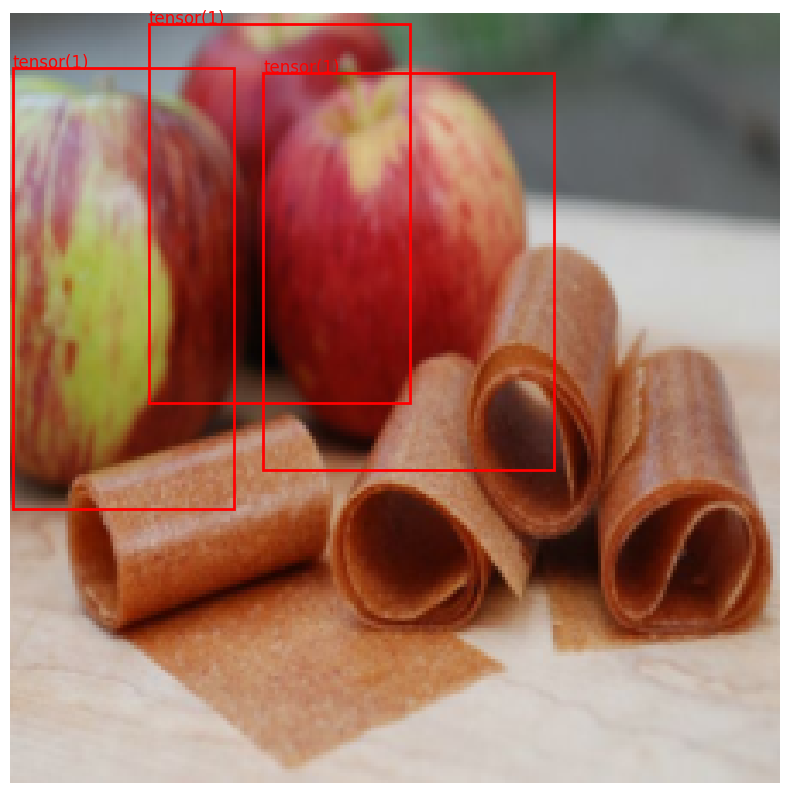

In [12]:
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt

batch_size = 16
num_workers = 8


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn = collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn = collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn= collate_fn)


# PLot an image sample
train_img_test = next(iter(train_loader))

image, label = train_img_test

fig = plt.figure(figsize=(10, 10))
plt.imshow(image[0].permute(1, 2, 0))
plt.axis('off')


for box, lab in zip(label[0]['boxes'], label[0]['labels']):
    
    x_min = box[0]
    y_min = box[1]

    w = (box[2] - box[0])
    h = (box[3] - box[1])

    plt.gca().add_patch(plt.Rectangle((x_min, y_min), w, h, fill=False, edgecolor='r', linewidth=2))
    plt.text(box[0], box[1], lab, fontsize=12, color='r')

plt.show()


In [13]:
# Create the main training loop
import warnings
warnings.filterwarnings("ignore")
import torch

device = 0
lr = 1e-2
num_epochs = 10


model = FruitDET().to(device)

#for param in model.model.backbone.parameters(): # Freeze the backbone layers
#    param.requires_grad = False

params_to_update = [p for p in model.parameters() if p.requires_grad] # Set the parameters to update to the ones that require grad
optimizer = torch.optim.SGD(params_to_update, lr=lr, momentum=0.9, weight_decay=0.0005)

loss_train = []
loss_test = []

loss_train_class = []
loss_test_class = []

loss_train_box = []
loss_test_box = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')

    train_loss, train_class_loss, train_box_loss = fit_fruitdet(model, device, train_loader, optimizer, 'train')
    print(f'Training --> Overall loss: {train_loss:.4f}, Class loss: {train_class_loss:.4f}, Box loss: {train_box_loss:.4f}')
    test_loss, test_class_loss, test_box_loss = fit_fruitdet(model, device, test_loader, optimizer, 'test')
    print(f'Testing --> Overall loss: {test_loss:.4f}, Class loss: {test_class_loss:.4f}, Box loss: {test_box_loss:.4f}')

    loss_train.append(train_loss)
    loss_test.append(test_loss)

    loss_train_class.append(train_class_loss)
    loss_test_class.append(test_class_loss)

    loss_train_box.append(train_box_loss)
    loss_test_box.append(test_box_loss)
    

Epoch 1/10
Training --> Overall loss: 0.5844, Class loss: 0.3064, Box loss: 0.2621
Testing --> Overall loss: 0.4056, Class loss: 0.1574, Box loss: 0.2307
Epoch 2/10
Training --> Overall loss: 0.3636, Class loss: 0.1516, Box loss: 0.1982
Testing --> Overall loss: 0.3355, Class loss: 0.1488, Box loss: 0.1672
Epoch 3/10
Training --> Overall loss: 0.2548, Class loss: 0.1082, Box loss: 0.1368
Testing --> Overall loss: 0.2560, Class loss: 0.0952, Box loss: 0.1474
Epoch 4/10
Training --> Overall loss: 0.1896, Class loss: 0.0668, Box loss: 0.1157
Testing --> Overall loss: 0.2196, Class loss: 0.0748, Box loss: 0.1324
Epoch 5/10
Training --> Overall loss: 0.1603, Class loss: 0.0510, Box loss: 0.1036
Testing --> Overall loss: 0.2045, Class loss: 0.0653, Box loss: 0.1269
Epoch 6/10
Training --> Overall loss: 0.1452, Class loss: 0.0459, Box loss: 0.0943
Testing --> Overall loss: 0.2009, Class loss: 0.0622, Box loss: 0.1259
Epoch 7/10
Training --> Overall loss: 0.1321, Class loss: 0.0422, Box loss: 

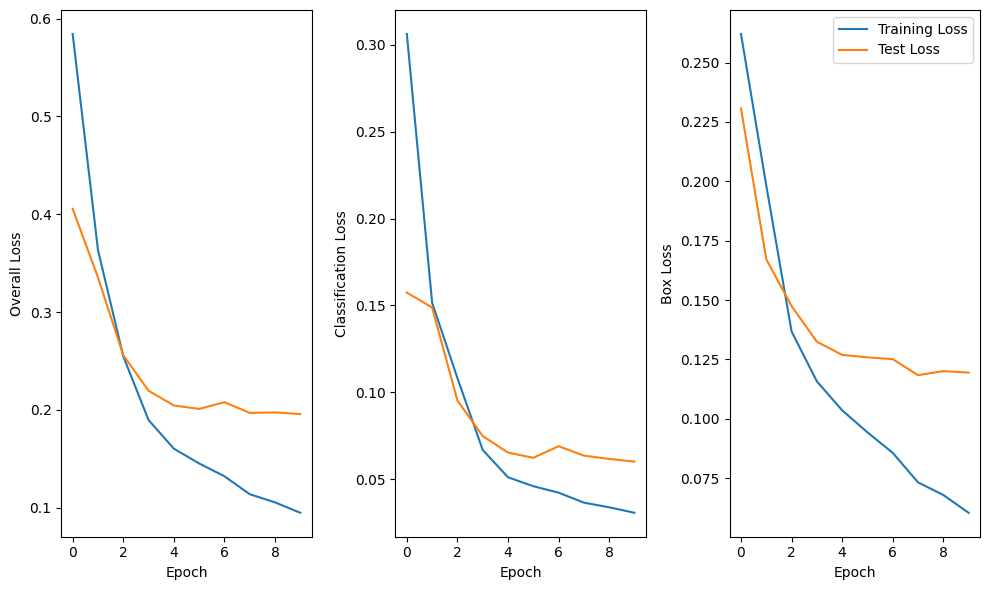

In [14]:
# PLot the three losses for the training and testing phases

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(10, 6))
axes[0].plot(loss_train, label='Training Loss')
axes[0].plot(loss_test, label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Overall Loss')

axes[1].plot(loss_train_class, label='Training Loss')
axes[1].plot(loss_test_class, label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Classification Loss')

axes[2].plot(loss_train_box, label='Training Loss')
axes[2].plot(loss_test_box, label='Test Loss')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Box Loss')

plt.legend()
plt.tight_layout()
plt.show()

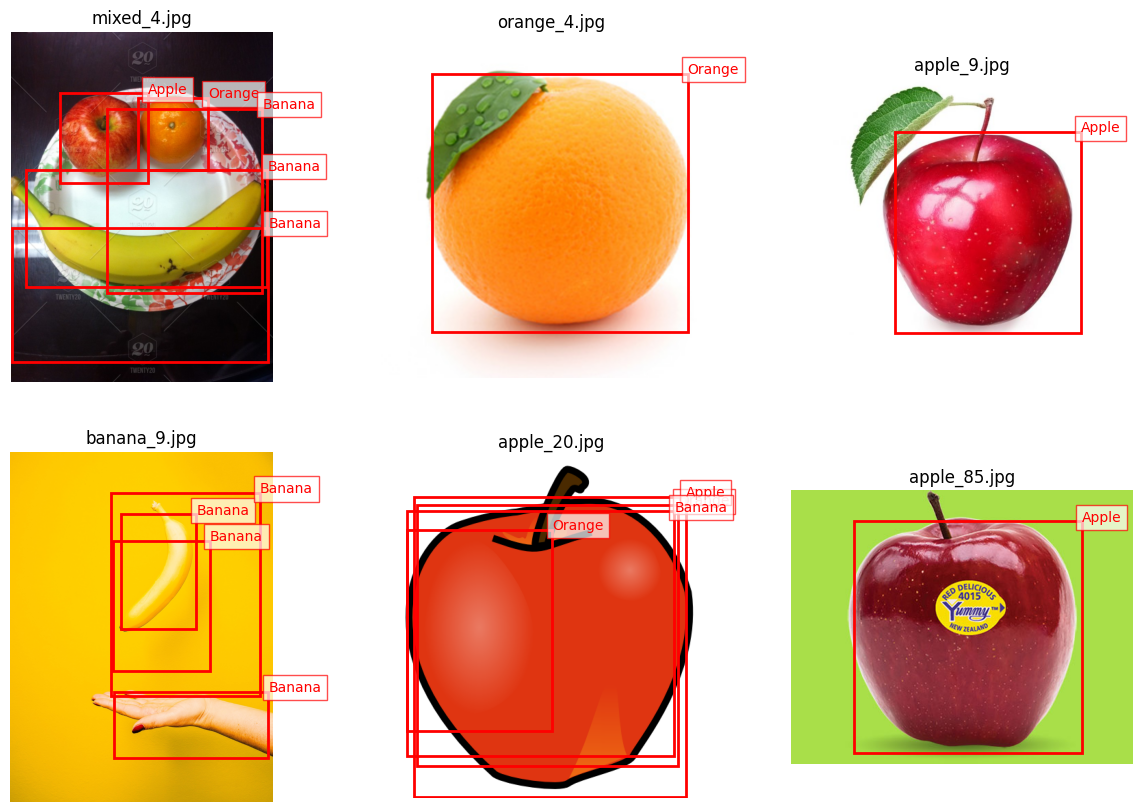

In [19]:
# plot a set of 6 images with predicted bounding boxes and labels
import numpy as np

image_list = np.random.choice(os.listdir(os.path.join('fruit_detection', 'images', 'valid')), 6)
image_list = [os.path.join('fruit_detection', 'images', 'valid', file) for file in image_list]

labels = [file.replace('.jpg', '.txt').replace('images', 'labels') for file in image_list]

model.eval()

labels = []
scores = []

for image_path in image_list:
    image = Image.open(image_path).convert('RGB')
    
    image_w, image_h = image.size

    image_tensor = transform(image).unsqueeze(0).to(device)
       
    prediction = model(image_tensor, None)

    lab_image = []
    scor_image = []
    
    for bbox, lab, scor in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
        
        x_min, y_min, x_max, y_max = bbox.detach().cpu().numpy()

        x_min = x_min * (image_w / 224)
        x_max = x_max * (image_w / 224)
        y_min = y_min * (image_h / 224)
        y_max = y_max * (image_h / 224)

        label = lab.detach().cpu().item()
        
        lab_image.append([label, float(x_min), float(y_min), float(x_max), float(y_max)])
        scor_image.append(scor.detach().cpu().item())
    
    labels.append(lab_image)
    scores.append(scor_image)

fig = plot_samples(image_list, labels)
plt.show()


In [20]:
# Computer Intersection over Union to check how much the boxes are overlapping
def compute_IoU(box1, box2):
    # Compute the intersection area
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    
    # Compute the union area
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union = area1 + area2 - intersection
    
    return intersection / union

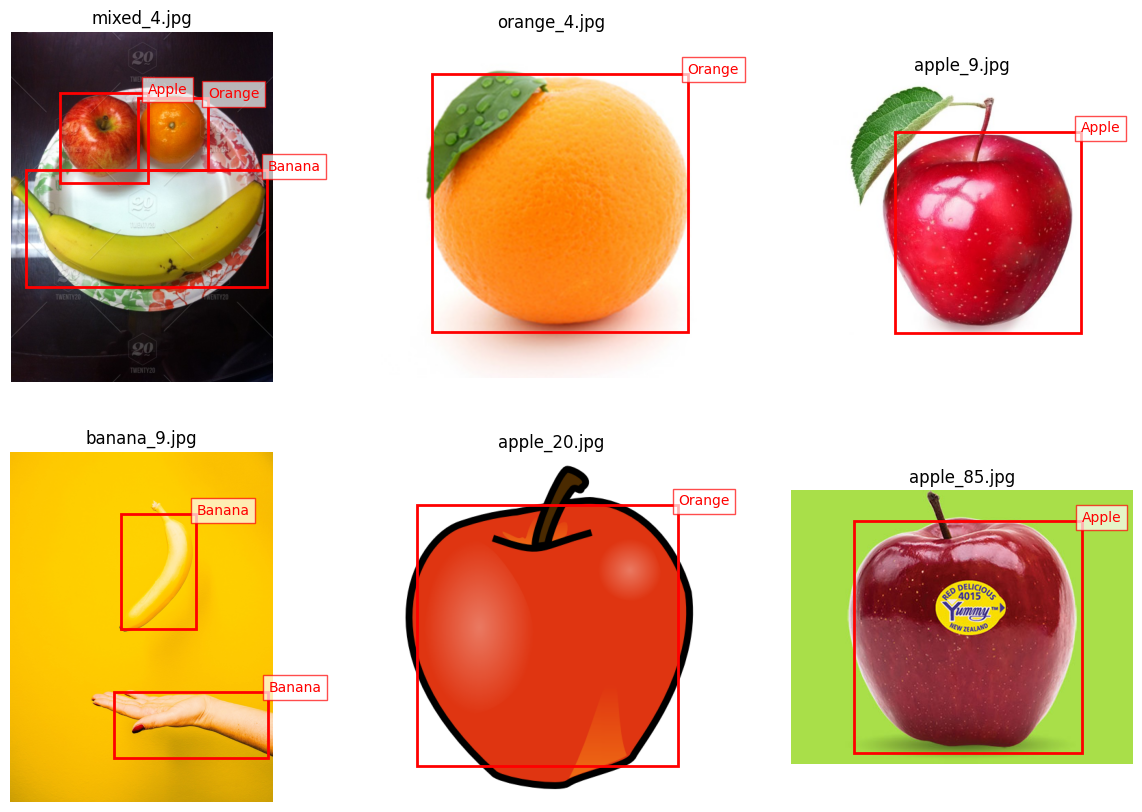

In [21]:
# Perform Non Maximum Suppression to remove overlapping bounding boxes

def non_max_suppression(boxes, scores, iou_threshold):
    # Create a list to store the final boxes
    final_boxes = []

    # Sort the boxes by their scores
    sorted_idx = np.argsort(scores)[::-1]
    
    # Iterate over the boxes
    while len(sorted_idx) > 0:
        # Get the index of the box with the highest score
        idx = sorted_idx[0]
        
        # Append the box to the final list
        final_boxes.append(boxes[idx])
        
        # Compute the IoU of the box with the rest of the boxes
        ious = [compute_IoU(boxes[idx], boxes[i]) for i in sorted_idx[1:]]
        
        # Get the indices of the boxes that have IoU higher than the threshold
        filtered_idx = np.where(np.array(ious) < iou_threshold)[0]
        
        # Keep only the boxes that have IoU lower than the threshold
        sorted_idx = sorted_idx[filtered_idx + 1]
        
    return final_boxes

# Perform Non Maximum Suppression to remove overlapping bounding boxes
final_boxes = []

for label, score in zip(labels, scores):
    final_boxes.append(non_max_suppression(label, score, 0.2))

fig = plot_samples(image_list, final_boxes)
plt.show()

### You Only Look Once (YOLO)

In [1]:
import yaml
from pathlib import Path

# Define the paths --> maybe not needed
settings_file = Path.home() / "/home/fabiotdt/.config/Ultralytics/settings.yaml" # Path to the Ultralytics setting file
custom_dataset_path = "/home/fabiotdt/Documents/rs_lab/fruit_detection"  # Path to the fruit_detection dataset
original_dataset_path = "/home/fabiotdt/Documents/datasets"  # Path to the original folder containing the datasets

# Function to update the settings file
def update_ultralytics_path(new_path):
    if settings_file.exists():
        with open(settings_file, "r") as file:
            settings = yaml.safe_load(file)
        settings["datasets_dir"] = new_path
        with open(settings_file, "w") as file:
            yaml.safe_dump(settings, file)
        print(f"Updated dataset directory to: {new_path}")
    else:
        raise FileNotFoundError(f"Settings file not found at {settings_file}")

In [ ]:
# Basic Training command

from ultralytics import YOLO

model = YOLO("../../weights_models/v8/yolov8n.pt")  # Load the weights of the model

# Train the model on your dataset
model.train(
    data="fruit_detection.yaml", # Path to the dataset YAML file
    epochs=30,                   # Number of training epochs
    batch=16,                    # Batch size
    imgsz=640,                   # Image size
    device=0,                    # GPU device (0 = first GPU, 'cpu' for CPU)
    workers=4,                   # Number of DataLoader workers
    save_period=-1,              # Save model every n epochs (-1 = don't save intermediate)
    project="fruit_det",   # Directory to save results
    name="base",      # Subfolder for the run
)

New https://pypi.org/project/ultralytics/8.3.69 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.150 🚀 Python-3.10.12 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24253MiB)
engine/trainer: task=detect, mode=train, model=../../weights_models/v8/yolov8n.pt, data=fruit_detection.yaml, epochs=30, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=4, project=fruit_det, name=base, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, ag

wandb: ERROR Error while calling W&B API: failed to find project f-taddeidallatorre/runs (<Response [404]>)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


In [ ]:
from ultralytics import YOLO
import wandb
from wandb.integration.ultralytics import add_wandb_callback

# Define the version of the YOLO model

model_name = '../../weights_models/v8/yolov8n'
dataset_name = 'fruit_detection.yaml'
model = YOLO(f"{model_name}.pt")
run_wandb = True

# Add the Weights & Biases callback to the model
wandb.init(project="fruit_detection", job_type="training", name = 'fruit_detection')


# Set some parameters for the model
TRAIN_CONFIG = dict(
    lr0=0.001,  # initial learning rate (i.e. SGD=1E-2, Adam=1E-3)a
    lrf=0.01,  # final learning rate (lr0 * lrf)
    optimizer="AdamW",  # Adam optimizer
    dropout=0.3 , # dropout
    momentum=0.9,  # SGD momentum/Adam beta1
    weight_decay=0.005,  # optimizer weight decay 5e-4
    warmup_epochs=1.0,  # warmup initial momentum
    warmup_bias_lr=0.1,  # warmup initial bias lr
    dfl=1.5,  # dfl loss gain
    label_smoothing=0.0,  # label smoothing (fraction)
    patience=250,
    augment=True,
    hsv_h=0.005,  # image HSV-Hue augmentation (fraction)
    hsv_s=1,  # image HSV-Saturation augmentation (fraction)
    hsv_v=0.7,  # image HSV-Value augmentation (fraction)
    degrees=0.3,  # image rotation (+/- deg)
    translate=0.3,  # image translation (+/- fraction)
    scale=0.8,  # image scale (+/- gain)
    shear=0.1,  # image shear (+/- deg) from -0.5 to 0.5
    perspective=0.01,  # image perspective (+/- fraction), range 0-0.001
    flipud=0.0,  # image flip up-down (probability)
    fliplr=0.0,  # image flip left-right (probability)
    mosaic=0.4,  # image mosaic (probability)
    mixup=0.5,  # image mixup (probability)
    copy_paste=0.0,  # segment copy-paste (probability)
)

# Define a freeze layer function to freeze the backbone of the model and train only the head

def freeze_layer(trainer):
    model = trainer.model
    num_freeze = 8 # freezed the backbone
    freeze = [f'model.{x}.' for x in range(num_freeze)]  # layers to freeze 
    for k, v in model.named_parameters(): 
        v.requires_grad = True  # train all layers 
        if any(x in k for x in freeze): 
            v.requires_grad = False 

# Update the Ultralytics settings file with the new path
#update_ultralytics_path(custom_dataset_path)

#model.add_callback("on_train_start", freeze_layer)
add_wandb_callback(model)


# Train the model
model.train(data=dataset_name, epochs=3, device = 0, workers = 4, save_period = -1,  **TRAIN_CONFIG) 


wandb.finish()


New https://pypi.org/project/ultralytics/8.3.69 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.150 🚀 Python-3.10.12 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24253MiB)
engine/trainer: task=detect, mode=train, model=../../weights_models/v8/yolov8n.pt, data=fruit_detection.yaml, epochs=3, patience=250, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=None, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.3, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=True, agnosti

Updated dataset directory to: /home/fabiotdt/Documents/rs_lab/fruit_detection


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

NOTE: When using the `ipython kernel` entry point, Ctrl-C will not work.

To exit, you will have to explicitly quit this process, by either sending
"quit" from a client, or using Ctrl-\ in UNIX-like environments.

To read more about this, see https://github.com/ipython/ipython/issues/2049


To connect another client to this kernel, use:
    --existing kernel-1814881.json
NOTE: When using the `ipython kernel` entry point, Ctrl-C will not work.

To exit, you will have to explicitly quit this process, by either sending
"quit" from a client, or using Ctrl-\ in UNIX-like environments.

To read more about this, see https://github.com/ipython/ipython/issues/2049


To connect another client to this kernel, use:
    --existing kernel-1814880.json


: 

In [82]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#model_name = 'fruit_detectio/base3/weights/best.pt'
#fruit_det = YOLO(model_name)

# Perform inference on a subset of the validation dataset
val_images = np.random.choice(os.listdir(os.path.join('fruit_detection', 'images', 'test')), 6)
val_images = [os.path.join('fruit_detection', 'images', 'test', file) for file in val_images]

img = Image.open(val_images[0]).convert('RGB')

plt.imshow(img)
plt.axis('off')
plt.show()


<Figure size 640x480 with 1 Axes>

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)



0: 448x640 4 oranges, 4.8ms
Speed: 1.8ms preprocess, 4.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 640x448 2 bananas, 68.7ms
Speed: 1.3ms preprocess, 68.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 480x640 1 apple, 1 banana, 5.4ms
Speed: 1.5ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 orange, 5.5ms
Speed: 1.8ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 2 bananas, 5.9ms
Speed: 1.7ms preprocess, 5.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 3 bananas, 5.4ms
Speed: 2.3ms preprocess, 5.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


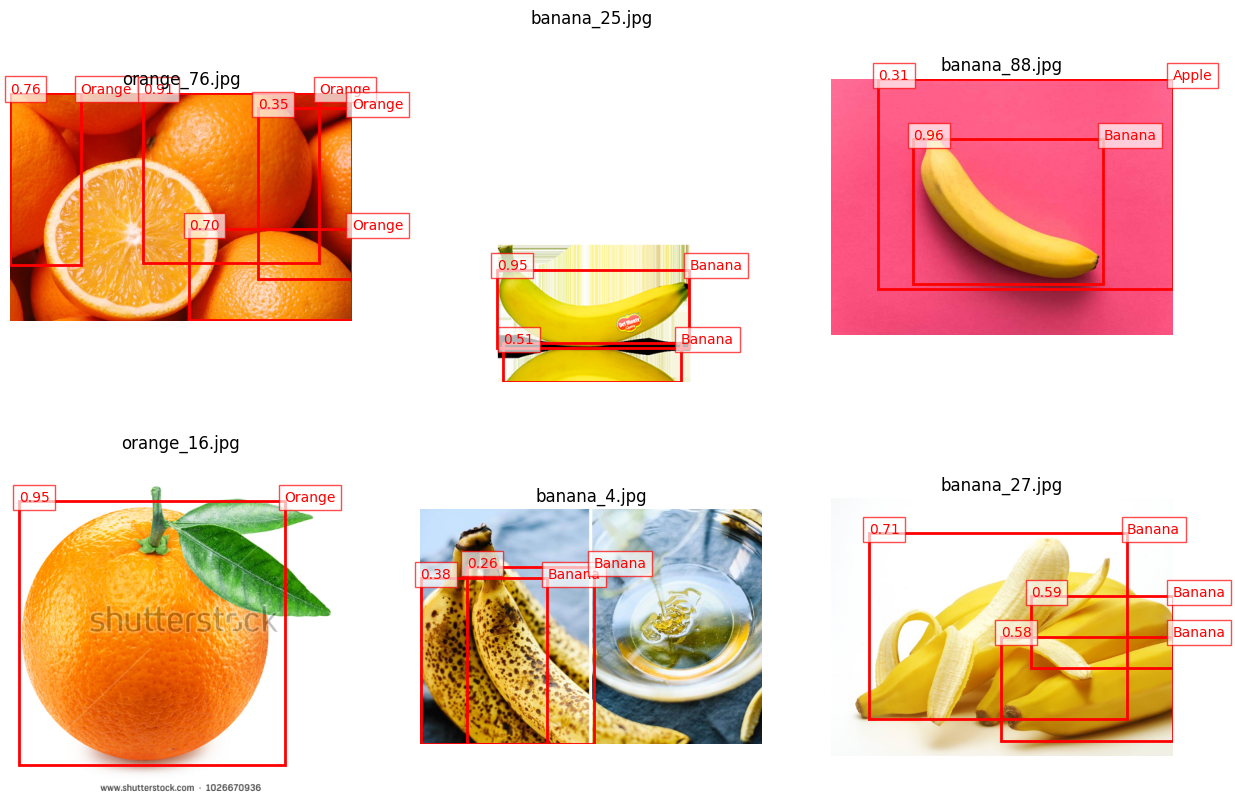

In [ ]:
# Load the model and perform inference
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

model_name = 'fruit_det/base/weights/best.pt'
fruit_det = YOLO(model_name)

# Perform inference on a subset of the validation dataset
val_images = np.random.choice(os.listdir(os.path.join('fruit_detection', 'images', 'test')), 6)
val_images = [os.path.join('fruit_detection', 'images', 'test', file) for file in val_images]


class_names = ['Apple', 'Banana', 'Orange']

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, image_path in enumerate(val_images):

    image = Image.open(image_path).convert('RGB')

    axs[i // 3, i % 3].imshow(image)
    axs[i // 3, i % 3].axis('off')
    axs[i // 3, i % 3].set_title(image_path.split('/')[-1])

    image_w, image_h = image.size

    prediction = fruit_det.predict(image)

    for pred in prediction[0].boxes.data.cpu().numpy():

        bbox, conf, lab = pred[:4], pred[4], pred[5]

        x_min, y_min, x_max, y_max = bbox
        
        x = x_min
        y = y_min
        w = (x_max - x_min)
        h = (y_max - y_min)

        rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2) # Plot the bbox
        axs[i // 3, i % 3].add_patch(rect)

        label = class_names[int(lab)]                       # Display the class
        axs[i// 3, i % 3].text(
            x + w, y, label, color='red', fontsize=10,
            bbox=dict(facecolor='white', edgecolor='red', alpha=0.7))

        axs[i// 3, i % 3].text(                             # Display the confidence
            x, y, f'{conf:.2f}', color='red', fontsize=10,
            bbox=dict(facecolor='white', edgecolor='red', alpha=0.7))

